<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS11_Gaussian_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

**Gaussian Variational Bayes**

<font color='red'>**IMPORTANTE: En este ejercicio se podrá importar numpy, matplotlib.pyplot y las funciones gamma, digamma y softmax de scipy.special (el resto deberá ser implementación propia).**</font>

Se desea modelar el tiempo (en minutos con respecto a la hora de entrada) en que diferentes grupos de estudiantes llegan a una determinada clase de la facultad. Estos comportamientos serán modelados como una mezcla de 6 comportamientos distintos dentro de las rutinas de las personas.

(a) *Creación del dataset:* Generar 100 muestras de una mezcla de gaussianas con pesos $0.1$, $0.4$, $0.2$, $0.3$, medias $-4$, $0$, $4$, $5$ y varianzas $1$, $1.96$, $1.44$, $1$ respectivamente. *Interpretación:* En realidad existían 4 comportamientos marcados (aunque nosotros no lo sabíamos). Ellos pueden pensarse como:
- Un 10\% de personas muy puntuales ($\mu=-4$ y varianza más pequeña).
- Un 40\% de personas que tienden a llega justo ($\mu=0$).
- Un 20\% de personas "relajadas" ($\mu=4$).
- Un 30\% de personas consistentemente impuntuales ($\mu=5$ y varianza más pequeña).

(b) *K-means:*

- Implementar un algoritmo de K-means para caracterizar la puntualidad de los estudiantes. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos $\texttt{init}$, $\texttt{fit}$ y $\texttt{predict}$.
- Modelar una mezcla de gaussianas con los resultados del entrenamiento. <img src="https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/consejero.png" width="25" />: Las medias sean los centroides, las varianzas sean estimadas intra-clase y los pesos sean la proporción de las muestras.
- Graficar la densidad estimada y compararla con la original.

(c) *Expectation-Maximization:*
- Implementar un algoritmo de EM para caracterizar la puntualidad de los estudiantes. Inicializar el algoritmo con el modelo de K-means. El entrenamiento debe contener doble condición de parada (numero de iteraciones y convergencia). El algoritmo EM debe ser definido dentro de una clase que posea al meos los métodos $\texttt{init}$, $\texttt{fit}$ y $\texttt{predict_proba}$ y $\texttt{predict}$.
- Graficar la densidad estimada, comparada con la de K-means y con la original.

(d) *Gaussian Variational Bayes:*
- Implementar un Variational Bayes Gaussiano que permita computar el modelo. Suponer *a priori* $m=0$, $\delta=\nu=\beta=0.05$ y $\alpha=(1,1,1,1,1,1)$, y utilizar el algoritmo EM para inicializar las probabilidades. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos $\texttt{init}$, $\texttt{fit}$ y $\texttt{predict_proba}$ y $\texttt{predict}$.
- Con la distribución *a posteriori* generar 3 muestras de parámetros y graficar la densidad de $X\vert\mu,\lambda,\pi$ para cada uno de esos conjuntos de parámetros. Compararla con la densidad verdadera, con la de K-means y con la de EM.
- Graficar la densidad *predictiva*. Compararla con la densidad verdadera, con la de K-means y con la del EM.


# Creación del dataset

En primer lugar, se generan $100$ muestras de una mezcla de $4$ gaussianas con:

- Pesos: $[0.1, 0.4, 0.2, 0.3]$

- Medias: $[-4, 0, 4, 5]$

- Varianzas: $[1, 1.96, 1.44, 1]$

Estas muestras **simulan los tiempos de llegada** a clase de distintos grupos de estudiantes.

La mezcla de gaussianas es una combinación de varias distribuciones normales ponderadas. Se simulará seleccionando primero a qué componente pertenece cada muestra según los pesos, y luego generando esa muestra según su media y varianza correspondiente.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definición de los parámetros de la mezcla de gaussianas
pesos = np.array([0.1, 0.4, 0.2, 0.3]) # Pesos (proporciones) de cada componente gaussiana
medias = np.array([-4, 0, 4, 5])     # Medias de cada componente gaussiana
varianzas = np.array([1.0, 1.96, 1.44, 1.0]) # Varianzas de cada componente gaussiana
desvios = np.sqrt(varianzas)         # Desviaciones estándar (raíz cuadrada de las varianzas)
n_samples = 100                      # Número total de muestras a generar

# Asignar cada una de las 100 muestras a una componente gaussiana según los pesos
# np.random.choice selecciona índices (0, 1, 2, o 3) con probabilidades dadas por 'pesos'
np.random.seed(3)
componentes = np.random.choice(len(pesos), size=n_samples, p=pesos)

# Generar las muestras de datos finales
# Se crea un array X vacío del tamaño de n_samples
X = np.array([
    # Para cada componente asignada a una muestra (k in componentes):
    # Se genera un número aleatorio de una distribución normal
    # con la media (loc) y desviación estándar (scale) de esa componente k
    np.random.normal(loc=medias[k], scale=desvios[k])
    for k in componentes # Itera sobre el array de componentes asignadas
])


# (b) K-Means

En el trabajo práctico 8 se aprendió que **K-means clustering**  es un método utilizado para encontrar clústeres y centros de clúster en un conjunto de datos sin etiquetas. El objetivo principal de este procedimiento es minimizar la varianza total dentro de un clúster.

K-means es un procedimiento iterativo. Dado un conjunto de entrenamiento $\left\{x^{(1)},\dots x^{n}\right\}$, para usarlo, se elige primero la cantidad deseada de centros de clúster $k$.

Luego, dado un conjunto inicial de centros $\mu_1, \mu_2,\dots \mu_k \in \mathbb{R}^d$, el algoritmo K-means alterna entre dos pasos principales:
- Para cada centro, se identifica el subconjunto de puntos de entrenamiento (su clúster) que está más cerca de él que de cualquier otro centro. Equivalentemente, para cada punto se identifica el centro más cercano:
$$c^{(i)}:=\arg\min_j\left\lVert x^{(i)}-\mu_j\right\rVert^2$$
- Se calculan las medias de cada característica para los puntos de datos en cada clúster, y este vector de media se convierte en el nuevo centro para ese clúster.
$$\mu_j:=\frac{\sum_{i=1}^n \mathbf{1}\left\{c^{(i)}=j\right\}x^{(i)}}{\sum_{i=1}^n \mathbf{1}\left\{c^{(i)}=j\right\}}$$

Este algoritmo **garantiza la convergencia** en cierto sentido. Si se define la función de distorsión:
$$J(c,\mu)=\sum_{i=1}^n\left\lVert x^{(i)}-\mu_{c^{(i)}}\right\rVert^2$$

Esto es, $J$ mide la suma del cuadrado de las distancias entre cada muestra $x^{(i)}$ y el centroide asignado $\mu_{c^{(i)}}$. Luego, se puede demostrar que K-means es un descenso de coordenadas sobre $J$. Específicamente, el bucle interno minimiza $J$ respecto a $c$ manteniendo $\mu$ fijo, y luego minimiza $J$ con respecto a $\mu$ manteniendo $c$ fijo. Entonces, $J$ debe disminuir monótonamente y el valor de $J$ debe converger (En teoría puede oscilar, pero esto casi nunca sucede en la práctica).

La función distorsión $J$ es una función no convexa, por lo que **no está garantizado que $J$ converja a un mínimo global**. En otras palabras, K-means puede ser susceptible a un óptimo local. Una práctica común es ejecutar K-means muchas veces usando valores iniciales distintos. Luego, de todos los diferentes resultados obtenidos, elegir el que da la distorsión menor $J(c,\mu)$.

## Implementación

A continuación, se reutiliza la implementación realizada anteriormente, en este caso, para caracterizar la puntualidad de los estudiantes.

In [2]:
from numpy.linalg import norm

class KMeans:
    """
    Implementación del algoritmo de clustering K-Means
    """
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None, n_init=100):
        """
        Inicializa el objeto de clustering KMeans.

        Args:
          n_clusters (int): Número de clústeres a formar.
          max_iter (int, opcional): Número máximo de iteraciones por cada inicialización. Por defecto es 100.
          tol (float, opcional): Tolerancia para la convergencia. El algoritmo se detiene si el cambio
                                 en los centros es menor que este valor. Por defecto es 1e-4.
          random_state (int o None, opcional): Determina la generación de números aleatorios
                                              para la inicialización de centroides. Por defecto es None.
          n_init (int, opcional): Número de veces que se ejecutará el algoritmo K-Means con diferentes
                                 semillas de centroides. El resultado final será el mejor en términos
                                 de distorsión. Por defecto es 1.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        # Para generar semillas para cada ejecución de n_init
        self.random_state = np.random.RandomState(random_state)
        self.n_init = n_init # Nuevo parámetro n_init
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None # Atributo para almacenar la distorsión del mejor resultado

    def fit(self, X):
        """
        Calcula el clustering de k-means n_init veces y selecciona el mejor resultado.

        Args:
          X (numpy.ndarray): Los datos de entrada a agrupar, con forma (n_muestras, n_características).

        Returns:
          self: El objeto KMeans ajustado.
        """
        n_samples, n_features = X.shape

        # Inicializa la mejor distorsión con infinito
        best_inertia = np.inf
        best_centers = None
        best_labels = None

        # Bucle exterior para ejecutar el algoritmo n_init veces
        for run in range(self.n_init):
            # Generar una semilla diferente para cada ejecución
            current_random_state = np.random.RandomState(self.random_state.randint(0, 2**32 - 1) if self.random_state else None)

            # Inicializar centroides aleatoriamente para esta ejecución
            centers = X[current_random_state.choice(n_samples, size=self.n_clusters, replace=False)]

            # Algoritmo KMeans para esta ejecución (bucle interior)
            for _ in range(self.max_iter):
                # Paso de Asignación
                distances = norm(X[:, None, :] - centers[None, :, :], axis=2)
                labels = np.argmin(distances, axis=1)

                # Paso de Actualización
                new_centers = np.array(
                    [X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j]
                     for j in range(self.n_clusters)]
                )

                # Verificar convergencia
                shift = norm(new_centers - centers, axis=1).mean()
                centers = new_centers

                if shift < self.tol:
                    break
                else:
                    pass

            # Calcular la distorsión para esta ejecución
            # Suma de distancias cuadradas de cada punto a su centroide asignado
            current_inertia = np.sum(norm(X - centers[labels], axis=1)**2)

            # Comparar con la mejor distorsión encontrada hasta ahora
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centers = centers.copy() # Usar .copy() para evitar problemas de referencia
                best_labels = labels.copy() # Usar .copy()

        # Almacenar los resultados del mejor ciclo
        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia # Almacenar la distorsión del mejor resultado

        return self

    def predict(self, X):
        """
        Predice el índice de clúster para cada muestra en los datos de entrada.

        Args:
          X (numpy.ndarray): Los datos de entrada para los que se predice los clústeres,
                             con forma (n_muestras, n_características).

        Returns:
          numpy.ndarray: Un array de índices de clúster, con forma (n_muestras,).
        """
        # Asigna cada punto de datos en X al clúster con el centro más cercano.
        return np.argmin(norm(X[:, None, :] - self.cluster_centers_[None, :, :], axis=2), axis=1)

## Modelado de una mezcla de gaussianas

Un **Modelo de Mezcla Gaussiana (GMM)** es una forma de modelar densidades de probabilidad complejas que no pueden ser representadas adecuadamente por una única distribución Gaussiana. Se define como una superposición lineal o combinación de $K$ densidades Gaussianas.

Cada componente de la mezcla es una distribución Gaussiana multivariada $\mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ con su propia media $\boldsymbol{\mu}_k$ y matriz de covarianza $\boldsymbol{\Sigma}_k$. Los parámetros del modelo incluyen los parámetros de cada componente Gaussiana y los coeficientes de mezcla $\pi_k$, que representan los pesos de cada componente en la mezcla.

Los GMMs se pueden interpretar en términos de variables latentes discretas. Para cada punto de datos, se asume una variable latente que indica qué componente de la mezcla fue responsable de generarlo. Esta visión permite formar distribuciones complicadas a partir de componentes más simples.

Dado que K-means no estima densidades directamente, se estima la mezcla gaussiana de la siguiente manera:
- Para cada cluster $k$, se toma la media $\mu_k$ como centroide.
- Se estima la varianza $\sigma^2_k$ como la varianza de los puntos dentro del cluster.
- Se estima $\pi_k$ como la fracción de puntos asignados al clúster $k$.

La densidad resultante es:
$$p(x)=\sum_{k=1}^K\pi_k \mathcal{N}(x\vert \mu_k,\sigma_k^2)$$

In [3]:
# Asegurarse de que X tiene forma (n_samples, n_features)
X_reshaped = X.reshape(-1, 1)

# Ajustar K-means con 6 componentes como pide el enunciado
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_reshaped)

# Obtener parámetros estimados
centroides = kmeans.cluster_centers_.flatten()
labels = kmeans.labels_

# Estimar pesos y varianzas
pesos_kmeans = np.array([(labels == k).mean() for k in range(6)])
varianzas_kmeans = np.array([
    np.var(X[labels == k]) if np.any(labels == k) else 1.0
    for k in range(6)
])
desvios_kmeans = np.sqrt(varianzas_kmeans)

# Definir la densidad estimada por K-means
def mezcla_kmeans_pdf(x):
    return sum(
        p * (1 / (np.sqrt(2 * np.pi * v))) * np.exp(-0.5 * ((x - m) ** 2) / v)
        for p, m, v in zip(pesos_kmeans, centroides, varianzas_kmeans)
    )

## Densidad original y estimada

A continuación, se grafica la densidad estimada de la mezcla comparada con la verdadera.

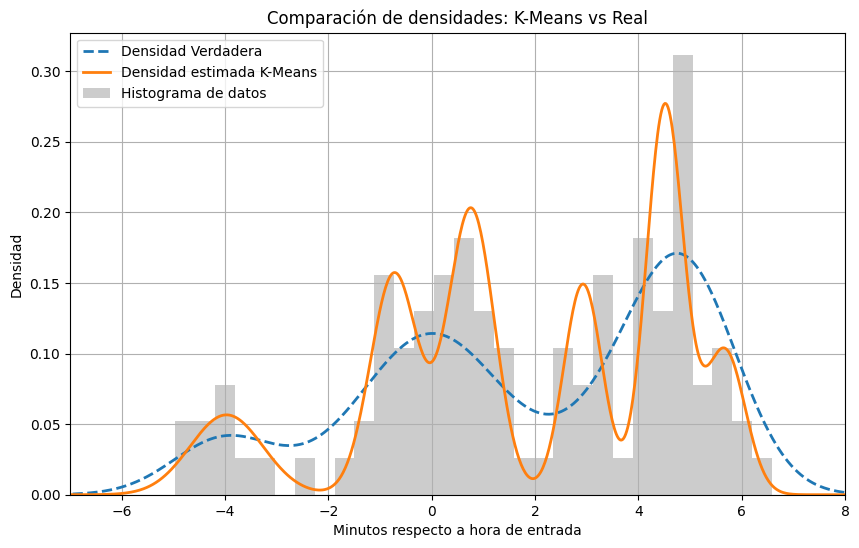

In [4]:
# Densidad verdadera para comparación
def mezcla_verdadera_pdf(x):
    return sum(
        p * (1 / (np.sqrt(2 * np.pi * v))) * np.exp(-0.5 * ((x - m) ** 2) / v)
        for p, m, v in zip(pesos, medias, varianzas)
    )

# Graficar ambas
x_plot = np.linspace(-10, 10, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x_plot, mezcla_verdadera_pdf(x_plot), 'C0--', lw=2, label='Densidad Verdadera')
plt.plot(x_plot, mezcla_kmeans_pdf(x_plot), 'C1-', lw=2, label='Densidad estimada K-Means')
plt.hist(X, bins=30, density=True, alpha=0.4, color='gray', label='Histograma de datos')
plt.title("Comparación de densidades: K-Means vs Real")
plt.xlabel("Minutos respecto a hora de entrada")
plt.ylabel("Densidad")
plt.legend()
plt.grid()
plt.xlim(-7,8)
plt.show()

La estimación de K-means detecta razonablemente bien los centros de las distribución real, es decir, las zonas con mayor densidad estimada coinciden con las zonas de alta probabilidad.

Como se usaron 6 clústeres para modelar una mezcla verdadera de 4 gaussianas, el modelo introduce picos innecesarios, sobreajustando los datos generados (la línea recorre bien el contorno del histograma).

K-means no modela correctamente la varianza ni el peso de forma adecuada, esto produce estimaciones incorrectas de la forma y amplitud de cada componente.

Este comportamiento sugiere que K-means puede ser útil como paso inicial, pero no como método final para modelar una mezcla de gaussianas.

# (c) Expectation-Maximization

La estimación de los parámetros de un GMM a partir de datos observados se realiza típicamente utilizando el método de Máxima Verosimilitud (MV). Sin embargo, la maximización directa de la función de verosimilitud es difícil debido a una suma dentro del logaritmo y el enfoque de MV presenta problemas de singularidades y múltiples máximos locales. Para abordar esto, se utiliza comúnmente el algoritmo **EM (Expectation-Maximization)**, que es un esquema iterativo.
- El **paso E (Expectación)** calcula las **responsabilidades**, que son las probabilidades a posteriori de que cada punto de datos pertenezca a cada componente, dadas las estimaciones actuales de los parámetros.
- El **paso M (Maximización)** reestima los parámetros del modelo utilizando estas responsabilidades calculadas en el paso E.























## Implementación

En este caso, la mezcla de gaussianas es modelada como:

$$p(x)=\sum_{k=1}^K\pi_k \mathcal{N}(x\vert \mu_k,\sigma_k^2)$$


El algoritmo EM alterna entre:
- Paso **E**: calcular responsabilidades
  $$\gamma_{nk}=\frac{\pi_k\mathcal{N}(x_n\vert \mu_k,\sigma_k^2)}{\sum_{j=1}^K\pi_j\mathcal{N}(x_n\vert \mu_k,\sigma_j^2)}$$
- Paso **M**: actualiza los parámetros
$$N_k=\sum_n\gamma_{nk},\;\;\;\pi_k=\frac{N_k}{N},\;\;\;\mu_k=\frac{1}{N_k}\sum\gamma_{nk}x_n,\;\;\;\sigma_k^2=\frac{1}{N_k}\sum_n\gamma_{nk}(x_n-\mu_k)^2$$


In [5]:
class EMGaussianMixture:
    """
    Implementación del algoritmo Expectation-Maximization (EM) para una Mezcla de Gaussianas (GMM).
    Este algoritmo estima los parámetros de las componentes gaussianas (pesos, medias, varianzas)
    que mejor se ajustan a los datos observados.
    """
    def __init__(self, n_components, max_iter=1000, tol=1e-6):
        """
        Inicializa el objeto EMGaussianMixture.

        Args:
          n_components (int): Número de componentes gaussianas en la mezcla.
          max_iter (int, opcional): Número máximo de iteraciones del algoritmo EM. Por defecto es 1000.
          tol (float, opcional): Tolerancia para la convergencia. El algoritmo se detiene
                                 si el cambio en la log-verosimilitud es menor que este valor.
                                 Por defecto es 1e-6.
        """
        self.n_components = n_components  # Número de componentes K
        self.max_iter = max_iter          # Máximo de iteraciones para el bucle EM
        self.tol = tol                    # Criterio de parada basado en la log-verosimilitud

        self.means_ = None    # Medias estimadas de las componentes (mu_k)
        self.vars_ = None     # Varianzas estimadas de las componentes (sigma^2_k)
        self.weights_ = None  # Pesos estimados de las componentes (pi_k)

    def _gaussian_pdf(self, x, mu, var):
        """
        Calcula la Densidad de Probabilidad (PDF) de una distribución Gaussiana univariada.

        Args:
          x (float o np.ndarray): El punto(s) en el que evaluar la PDF.
          mu (float): La media de la distribución Gaussiana.
          var (float): La varianza de la distribución Gaussiana.

        Returns:
          float o np.ndarray: El valor(es) de la PDF en el punto(s) especificado.
        """
        # Asegura que la varianza sea positiva para evitar errores (log(0))
        var = np.maximum(var, 1e-9)
        # Fórmula de la PDF Gaussiana univariada
        return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * (x - mu)**2 / var)

    def fit(self, X, init_means=None, init_vars=None, init_weights=None):
        """
        Ajusta el modelo de Mezcla de Gaussianas a los datos de entrada X usando el algoritmo EM.

        La inicialización de los parámetros (medias, varianzas, pesos) puede ser proporcionada
        o se inicializará de forma predeterminada.

        Args:
          X (numpy.ndarray): Los datos de entrada para el ajuste, con forma (n_muestras,).
          init_means (np.ndarray, opcional): Medias iniciales para las componentes. Forma (n_components,).
                                            Si es None, se inicializa aleatoriamente. Por defecto es None.
          init_vars (np.ndarray, opcional): Varianzas iniciales para las componentes. Forma (n_components,).
                                           Si es None, se inicializa con unos. Por defecto es None.
          init_weights (np.ndarray, opcional): Pesos iniciales para las componentes. Forma (n_components,).
                                              Si es None, se inicializa uniformemente. Por defecto es None.

        Returns:
          self: El objeto EMGaussianMixture ajustado.
        """
        N = X.shape[0]  # Número de muestras
        # Asegura que X tenga la forma correcta para operaciones (n_muestras, 1)
        X = X.reshape(-1, 1)

        # --- Inicialización de Parámetros ---
        # Inicializa las medias si no se proporcionan
        if init_means is None:
            # Selecciona n_components puntos de datos aleatorios como medias iniciales
            idx = np.random.choice(N, self.n_components, replace=False)
            self.means_ = X[idx].flatten() # Aplanar a 1D
        else:
            self.means_ = init_means

        # Inicializa las varianzas si no se proporcionan
        if init_vars is None:
            # Inicializa todas las varianzas a 1.0
            self.vars_ = np.ones(self.n_components)
        else:
            self.vars_ = init_vars

        # Inicializa los pesos si no se proporcionan
        if init_weights is None:
            # Inicializa los pesos uniformemente (1/n_components para cada componente)
            self.weights_ = np.ones(self.n_components) / self.n_components
        else:
            self.weights_ = init_weights

        # Asegura que los pesos iniciales sumen 1
        self.weights_ /= self.weights_.sum()
        # Asegura que las varianzas iniciales sean positivas
        self.vars_ = np.maximum(self.vars_, 1e-9)

        # Variable para almacenar la log-verosimilitud de la iteración anterior para verificar convergencia
        log_likelihood_old = -np.inf

        # --- Bucle Principal del Algoritmo EM ---
        for _ in range(self.max_iter):
            # --- Paso E (Expectación) ---
            # Calcula las responsabilidades (gamma_{nk}): la probabilidad a posteriori
            # de que la muestra n pertenezca a la componente k.
            gamma = np.zeros((N, self.n_components)) # Inicializa la matriz de responsabilidades
            for k in range(self.n_components):
                # gamma_{nk} = pi_k * N(x_n | mu_k, sigma^2_k)
                gamma[:, k] = self.weights_[k] * self._gaussian_pdf(X.flatten(), self.means_[k], self.vars_[k])

            # Normaliza las responsabilidades para que sumen 1 para cada muestra
            # gamma_{nk} = (pi_k * N(x_n | mu_k, sigma^2_k)) / sum_j (pi_j * N(x_n | mu_j, sigma^2_j))
            gamma_sum_rows = gamma.sum(axis=1, keepdims=True)
            # Evita la división por cero si una muestra está muy lejos de todas las componentes
            gamma /= np.maximum(gamma_sum_rows, 1e-12)


            # --- Paso M (Maximización) ---
            # Actualiza los parámetros (pi, mu, sigma^2) para maximizar la log-verosimilitud esperada.

            # N_k es la suma de las responsabilidades para cada componente k (número efectivo de puntos en el clúster k)
            N_k = gamma.sum(axis=0)

            # Actualiza los pesos (pi_k)
            # pi_k = N_k / N
            self.weights_ = N_k / N
            # Asegura que los pesos sean positivos y vuelvan a sumar 1
            self.weights_ = np.maximum(self.weights_, 1e-9)
            self.weights_ /= self.weights_.sum()


            # Actualiza las medias (mu_k)
            # mu_k = sum_n (gamma_{nk} * x_n) / N_k
            # (gamma.T @ X) realiza la suma ponderada de las muestras por sus responsabilidades
            # Evita la división por cero si N_k es cero para alguna componente
            valid_N_k = np.maximum(N_k, 1e-9)
            self.means_ = (gamma.T @ X).flatten() / valid_N_k

            # Actualiza las varianzas (sigma^2_k)
            # sigma^2_k = sum_n (gamma_{nk} * (x_n - mu_k)^2) / N_k
            # Calcula la suma ponderada de las diferencias cuadráticas respecto a la nueva media
            self.vars_ = np.array([
                np.sum(gamma[:, k] * (X.flatten() - self.means_[k])**2) / valid_N_k[k]
                for k in range(self.n_components)
            ])
            # Asegura que las varianzas sean positivas
            self.vars_ = np.maximum(self.vars_, 1e-9)

            # --- Verificación de Convergencia ---
            # Calcula la log-verosimilitud del modelo actual
            log_likelihood = np.sum(np.log(np.sum([
                self.weights_[k] * self._gaussian_pdf(X.flatten(), self.means_[k], self.vars_[k])
                for k in range(self.n_components)
            ], axis=0)))

            # Compara el cambio en la log-verosimilitud con la tolerancia
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break # Si el cambio es pequeño, el algoritmo ha convergido

            # Actualiza la log-verosimilitud anterior para la próxima iteración
            log_likelihood_old = log_likelihood

        # Almacena las responsabilidades finales
        self.resp_ = gamma

        # Devuelve el objeto ajustado (self)
        return self

    def predict_proba(self, X):
        """
        Calcula las probabilidades a posteriori (responsabilidades) de cada muestra
        pertenecer a cada componente, dado el modelo ajustado.

        Args:
          X (numpy.ndarray): Los datos de entrada para los que calcular probabilidades,
                             con forma (n_muestras,).

        Returns:
          numpy.ndarray: Un array de responsabilidades, con forma (n_muestras, n_components).
                         Cada fila suma 1.
        """
        # Asegura que X tenga la forma correcta
        X = X.reshape(-1, 1)
        N = X.shape[0]

        # Calcula las responsabilidades de la misma manera que en el Paso E del método fit
        gamma = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            gamma[:, k] = self.weights_[k] * self._gaussian_pdf(X.flatten(), self.means_[k], self.vars_[k])

        gamma_sum_rows = gamma.sum(axis=1, keepdims=True)
        # Normaliza y evita la división por cero
        return gamma / np.maximum(gamma_sum_rows, 1e-12)

    def predict(self, X):
        """
        Predice la etiqueta del clúster (componente) para cada muestra
        basándose en la asignación más probable (hard assignment).

        Args:
          X (numpy.ndarray): Los datos de entrada para la predicción, con forma (n_muestras,).

        Returns:
          numpy.ndarray: Un array de etiquetas de clúster (índices de componente),
                         con forma (n_muestras,).
        """
        # Calcula las probabilidades a posteriori y devuelve el índice de la componente con mayor probabilidad
        return np.argmax(self.predict_proba(X), axis=1)

## Ajuste

Una vez implementado el algoritmo de Expectation-Maximization (EM) para mezcla de gaussianas, se ajusta el modelo a los datos generados.

Se inicia con los parámetros obtenidos previamente mediante K-means para facilitar la convergencia.

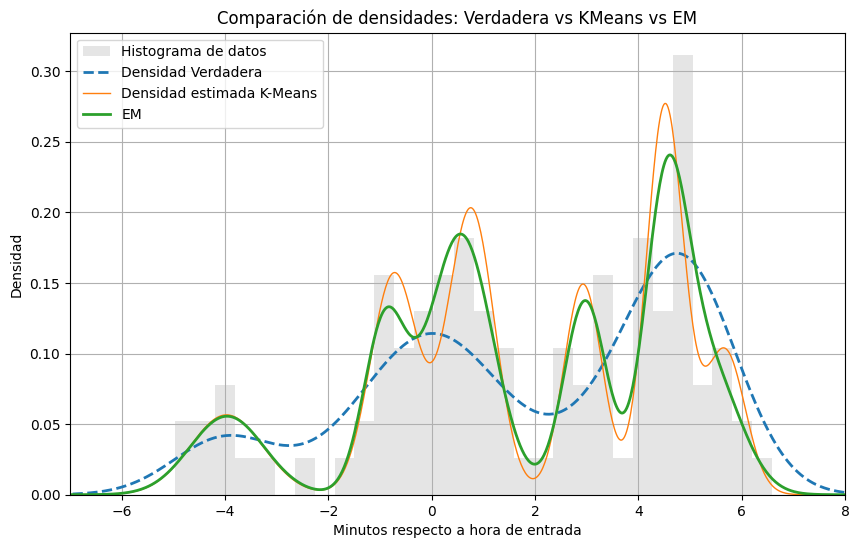

In [6]:
# Inicialización desde KMeans
em = EMGaussianMixture(n_components=6)
em.fit(X_reshaped, init_means=centroides, init_vars=varianzas_kmeans, init_weights=pesos_kmeans)

# Graficar densidad estimada por EM
def mezcla_em_pdf(x):
    return sum(
        p * (1 / np.sqrt(2 * np.pi * v)) * np.exp(-0.5 * ((x - m)**2) / v)
        for p, m, v in zip(em.weights_, em.means_, em.vars_)
    )

plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, density=True, alpha=0.2, color='gray', label='Histograma de datos')
plt.plot(x_plot, mezcla_verdadera_pdf(x_plot), 'C0--', lw=2, label='Densidad Verdadera')
plt.plot(x_plot, mezcla_kmeans_pdf(x_plot), 'C1-', lw=1, label='Densidad estimada K-Means')
plt.plot(x_plot, mezcla_em_pdf(x_plot),'C2-', lw=2, label='EM')
plt.title("Comparación de densidades: Verdadera vs KMeans vs EM")
plt.xlabel("Minutos respecto a hora de entrada")
plt.ylabel("Densidad")
plt.legend()
plt.xlim(-7,8)
plt.grid()
plt.show()


El modelo EM mejora la estimación de la densidad comparado con K-means. EM ajusta mejor las varianzas, ya que lo hace de forma probabilística. Sin embargo, el uso de 6 componentes, en vez de 4, nuevamente produce artefactos.

Esto muestra una mejora sobre el método K-means, aunque también muestra sus límites en cuanto a la complejidad del modelo y posible sobreajuste.


# (d) Gaussian Variational Bayes

Gaussian Variational Bayes es un método de inferencia aproximada que se utiliza para estimar la distribución a posteriori de los parámetros y variables latentes en modelos probabilísticos, particularmente aquellos que involucran distribuciones Gaussianas, como los Modelos de Mezcla de Gaussianas.

La filosofía bayesiana interpreta la probabilidad como una medida de credibilidad o incertidumbre. Los métodos bayesianos, incluyendo Variational Bayes, buscan cuantificar esta incertidumbre sobre los parámetros (como la media y la covarianza) y las variables latentes (como las asignaciones de clústeres en una mezcla) dado un conjunto de datos observados.

Dado que calcular la distribución a posteriori exacta $p(Z|X)$ (donde $Z$ son las variables latentes y parámetros, y $X$ son los datos observados) a menudo es intratable, Variational Bayes busca aproximarla con una distribución más simple $q(Z)$.

La aproximación $q(Z)$ se elige para minimizar la divergencia Kullback-Leibler (KL) con respecto a la verdadera distribución posterior $p(Z|X)$, $KL(q(Z)||p(Z|X))$. Esto es equivalente a maximizar una función conocida como la Evidencia de Límite Inferior (ELBO). El ELBO proporciona un límite inferior en el logaritmo de la evidencia del modelo, lo que es útil para la selección del modelo.

Una suposición clave que hace que Variational Bayes sea manejable es la aproximación de campo medio. Esta supone que la distribución $q(Z)$ puede factorizarse como un producto de distribuciones más simples sobre subconjuntos disjuntos de las variables latentes y los parámetros. Por ejemplo, para un modelo de mezcla de Gaussianas, la posterior $q(Z, \pi, \mu, \Lambda)$ puede factorizarse como $q(Z)q(\pi)q(\mu, \Lambda)$.

En el contexto de Gaussian Variational Bayes con Mezcla de Gaussianas, las variables latentes incluyen las asignaciones de clústeres para cada punto de datos ($z_n$) y los parámetros del modelo, como los pesos de mezcla ($\pi$), las medias ($\mu_k$) y las matrices de precisión ($\Lambda_k$) de cada componente Gaussiana.

Se introducen distribuciones previas conjugadas para los parámetros, por ejemplo, una distribución de Dirichlet para los pesos de mezcla $\pi$ y distribuciones Gaussianas-Wishart (o Gaussianas-Gamma para el caso univariado) para las medias y precisiones de las componentes Gaussianas.

La maximización del ELBO se realiza típicamente de forma iterativa, actualizando cada factor $q_i(Z_i)$ secuencialmente mientras se mantienen fijos los otros factores. Estas actualizaciones a menudo tienen la forma de exponenciales de expectativas del logaritmo de la distribución conjunta,

Para un modelo de mezcla de Gaussianas, esto se asemeja al algoritmo Expectation-Maximization (EM). En el paso "E" (variacional), se actualiza la distribución $q(Z)$ de las variables latentes (las responsabilidades $\gamma_{nk}$). En el paso "M" (variacional), se actualizan las distribuciones $q(\pi)$, $q(\mu_k, \Lambda_k)$ de los parámetros, utilizando las expectativas de las responsabilidades.

## Implementación

In [7]:
from scipy.special import gamma, digamma, softmax
import numpy as np # Importar numpy explícitamente

class VariationalBayesGMM:
    """
    Implementación del algoritmo Gaussian Variational Bayes para una Mezcla de Gaussianas univariada.
    Este algoritmo estima una distribución aproximada q(Z) sobre las variables latentes y parámetros
    para aproximar la distribución a posteriori p(Z|X), maximizando la Evidencia de Límite Inferior (ELBO).
    """
    def __init__(self, n_components=6, max_iter=1000, tol=1e-6):
        """
        Inicializa el objeto VariationalBayesGMM.

        Args:
          n_components (int): Número de componentes gaussianas en la mezcla (K).
          max_iter (int, opcional): Número máximo de iteraciones del algoritmo de Variational Bayes. Por defecto es 1000.
          tol (float, opcional): Tolerancia para la convergencia. El algoritmo se detiene si el cambio
                                 en una métrica (aquí, la suma de alpha) es menor que este valor.
                                 Por defecto es 1e-6.
        """
        self.K = n_components  # Número de componentes K
        self.max_iter = max_iter # Máximo de iteraciones para el bucle VB
        self.tol = tol         # Criterio de parada basado en el cambio en los parámetros variacionales

        # --- Hiperparámetros de las distribuciones a priori conjugadas ---
        # Priori para las medias (mu_k): Gaussiana con media m0 y precisión beta0 * lambda_k
        self.m0 = 0
        self.beta0 = 0.05

        # Priori para las precisiones (lambda_k): Gamma con forma nu0/2 y tasa delta0/2
        self.nu0 = 0.05
        self.delta0 = 0.05

        # Priori para los pesos (pi_k): Dirichlet con parámetro alpha0
        self.alpha0 = np.ones(self.K) # Vector de unos de tamaño K para una priori uniforme

        # Parámetros variacionales que serán aprendidos
        self.alpha_ = None # Parámetro de la Dirichlet posterior para los pesos (q(pi))
        self.beta_ = None  # Parámetro de la Gaussiana-Gamma posterior para las medias (q(mu, lambda))
        self.nu_ = None    # Parámetro de la Gaussiana-Gamma posterior para las precisiones (q(mu, lambda))
        self.m_ = None     # Parámetro de la Gaussiana-Gamma posterior para las medias (q(mu, lambda))
        self.delta_ = None # Parámetro de la Gaussiana-Gamma posterior para las precisiones (q(mu, lambda))
        self.r_ = None     # Responsabilidades (probabilidades a posteriori de asignación de clúster, q(z))


    def fit(self, X, init_resp=None):
        """
        Ajusta el modelo de Mezcla de Gaussianas usando el algoritmo Variational Bayes.

        Calcula las distribuciones a posteriori aproximadas q(pi), q(mu, lambda) y q(z).

        Args:
          X (numpy.ndarray): Los datos de entrada para el ajuste, con forma (n_muestras,).
          init_resp (np.ndarray, opcional): Responsabilidades iniciales para el paso E.
                                           Si es None, se inicializa aleatoriamente.
                                           Una buena práctica es usar las responsabilidades de EM.
                                           Forma (n_muestras, n_components). Por defecto es None.

        Returns:
          self: El objeto VariationalBayesGMM ajustado con los parámetros variacionales aprendidos.
        """
        # Asegura que X tenga la forma correcta (n_muestras, 1) para operaciones matriciales
        X = X.reshape(-1, 1)
        N = len(X)  # Número de muestras

        # --- Inicialización de las Responsabilidades (q(z)) ---
        # Estas responsabilidades (r_{nk}) son las probabilidades a posteriori de que la muestra n
        # haya sido generada por la componente k, dadas las expectativas de los parámetros.
        if init_resp is None:
            # Si no se proporcionan responsabilidades iniciales, se inicializan aleatoriamente
            # usando una distribución Dirichlet para cada muestra.
            r = np.random.dirichlet(np.ones(self.K), N)
        else:
            # Si se proporcionan, se usan las responsabilidades iniciales (por ejemplo, de EM)
            r = init_resp

        # --- Cálculo de Estadísticas Suficientes Iniciales a partir de las responsabilidades ---
        # Estas estadísticas son necesarias para inicializar los parámetros variacionales posteriores.
        Nk = r.sum(axis=0) # Nk = sum_n r_{nk} (número efectivo de puntos asignados a la componente k)
        # xk_bar = sum_n r_{nk} * x_n / Nk (media ponderada de las muestras asignadas a la componente k)
        # Evita la división por cero si Nk es 0 para alguna componente
        xk_bar = (r.T @ X).flatten() / np.maximum(Nk, 1e-9)

        # --- Inicialización de los Parámetros Variacionales Posteriores ---
        # Estos son los parámetros de las distribuciones q(pi), q(mu, lambda).
        # Se inicializan usando las fórmulas de actualización del paso M variacional
        # con las estadísticas suficientes iniciales.

        # Parámetro alpha de la Dirichlet posterior q(pi)
        alpha = self.alpha0 + Nk

        # Parámetros beta y nu de la Gaussiana-Gamma posterior q(mu, lambda)
        beta = self.beta0 + Nk
        nu = self.nu0 + Nk

        # Parámetro m de la Gaussiana-Gamma posterior q(mu, lambda)
        m = (self.beta0 * self.m0 + Nk * xk_bar) / beta

        # Parámetro delta de la Gaussiana-Gamma posterior q(mu, lambda)
        delta = np.zeros(self.K)
        for k in range(self.K):
            # sum_n r_{nk} * x_n^2 (suma ponderada de los cuadrados de las muestras)
            x2_sum_weighted = np.sum(r[:, k] * X.flatten()**2)
            # Fórmula de actualización para delta_k
            delta[k] = (
                self.delta0 +
                x2_sum_weighted +
                self.beta0 * self.m0**2 -
                beta[k] * m[k]**2
            )
        # Asegura que delta sea positivo para evitar errores logarítmicos
        delta = np.maximum(delta, 1e-9)


        # Variable para almacenar la métrica de convergencia de la iteración anterior
        # Usamos la suma de alpha como proxy para el ELBO para verificar la convergencia.
        elbo_old = -np.inf # Inicializamos con un valor muy bajo

        # --- Bucle Principal del Algoritmo Variational Bayes ---
        for _ in range(self.max_iter):
            # === Paso E (Variacional) ===
            # Actualiza las responsabilidades (r_{nk}) calculando las expectativas necesarias
            # bajo las distribuciones q actuales y luego aplicando softmax.

            # Expectativa del logaritmo de los pesos de mezcla: E[log pi_k]
            E_log_pi = digamma(alpha) - digamma(np.sum(alpha))

            # Expectativa del logaritmo de las precisiones: E[log lambda_k]
            # digamma(nu/2) - log(delta/2) es la expectativa del logaritmo de una Gamma(nu/2, delta/2)
            E_log_lambda = digamma(nu / 2) - np.log(delta / 2)

            # Expectativa de las precisiones: E[lambda_k]
            E_lambda = nu / delta # Media de una distribución Gamma(nu/2, delta/2)

            # Expectativa del término cuadrático en el exponente de la Gaussiana: E[(x_n - mu_k)^2 * lambda_k]
            # Esto se descompone usando E[lambda_k * mu_k^2], E[lambda_k * mu_k], E[lambda_k].
            # La expectativa E[(x - mu)^2 * lambda] bajo q(mu, lambda) = E[lambda] * E[(x - mu)^2]
            # E[(x - m)^2 + 1/beta] = (x - m)^2 + E[1/beta] donde E[1/beta] = 1/beta para q(mu, lambda)
            E_quad = (X - m.reshape(1, -1))**2 + 1 / beta.reshape(1, -1)

            # Calcula log(rho_{nk}) = E[log p(x_n, z_n=k | pi, mu, lambda)] + const
            # log(rho_{nk}) = E[log pi_k] + E[log N(x_n | mu_k, lambda_k^-1)]
            # log N(x | mu, lambda^-1) = 0.5 log lambda - 0.5 log(2pi) - 0.5 lambda (x - mu)^2
            log_rho = (
                E_log_pi +          # E[log pi_k]
                0.5 * E_log_lambda - # 0.5 * E[log lambda_k]
                0.5 * np.log(2 * np.pi) - # Constante
                0.5 * E_lambda * E_quad # -0.5 * E[lambda_k * (x_n - mu_k)^2]
            )

            # Calcula las responsabilidades r_{nk} normalizando log_rho usando softmax.
            # r_{nk} = exp(log_rho_{nk}) / sum_j exp(log_rho_{nj})
            r = softmax(log_rho, axis=1)

            # === Paso M (Variacional) ===
            # Actualiza los parámetros variacionales (alpha, beta, nu, m, delta)
            # utilizando las responsabilidades r_{nk} calculadas en el paso E.

            # Recalcula las estadísticas suficientes a partir de las nuevas responsabilidades
            Nk = r.sum(axis=0)
            # Evita la división por cero
            valid_Nk = np.maximum(Nk, 1e-9)
            xk_bar = (r.T @ X).flatten() / valid_Nk

            # Actualiza los parámetros variacionales de las distribuciones posteriores
            alpha = self.alpha0 + Nk
            beta = self.beta0 + Nk
            nu = self.nu0 + Nk

            m = (self.beta0 * self.m0 + Nk * xk_bar) / beta

            for k in range(self.K):
                x2_sum_weighted = np.sum(r[:, k] * X.flatten()**2)
                delta[k] = (
                    self.delta0 +
                    x2_sum_weighted +
                    self.beta0 * self.m0**2 -
                    beta[k] * m[k]**2
                )
            # Asegura que delta sea positivo
            delta = np.maximum(delta, 1e-9)


            # --- Verificación de Convergencia ---
            # Compara el cambio en la suma de alpha con la tolerancia.
            # El ELBO es una función compleja, pero el cambio en la suma de alpha
            # (relacionado con la parte de la Dirichlet en el ELBO) es un indicador
            # práctico de si el algoritmo se ha estabilizado.
            elbo = np.sum(alpha) # Usamos la suma de alpha como métrica de convergencia
            if np.abs(elbo - elbo_old) < self.tol:
                break # Si el cambio es pequeño, el algoritmo ha convergido

            # Actualiza la métrica anterior para la próxima iteración
            elbo_old = elbo

        # --- Fin del bucle VB ---
        # Almacena los parámetros variacionales finales y las responsabilidades finales
        self.r_ = r
        self.alpha_, self.beta_, self.nu_, self.m_, self.delta_ = alpha, beta, nu, m, delta

        # Devuelve el objeto ajustado (self)
        return self

    def sample_parameters(self):
        """
        Genera una muestra de (pi, mu, lambda) de las distribuciones posteriores variacionales.

        Permite visualizar la variabilidad posterior de los parámetros.

        Returns:
          tuple: Una tupla conteniendo:
                 - pi (np.ndarray): Una muestra de los pesos de mezcla de la Dirichlet posterior.
                 - mus (np.ndarray): Una muestra de las medias de las Gaussianas posteriores.
                 - lambdas (np.ndarray): Una muestra de las precisiones de las Gammas posteriores.
        """
        # Muestrear pesos (pi) de la Dirichlet posterior q(pi) ~ Dir(alpha_)
        pi = np.random.dirichlet(self.alpha_)

        # Muestrear precisiones (lambda) de las Gammas posteriores q(lambda_k) ~ Gamma(nu_k/2, delta_k/2)
        # Nota: np.random.gamma usa shape y scale (scale = 1/rate)
        lambdas = np.random.gamma(self.nu_ / 2, scale=2 / self.delta_)

        # Muestrear medias (mu) de las Gaussianas posteriores q(mu_k | lambda_k) ~ N(m_k, (beta_k * lambda_k)^-1)
        # La desviación estándar es sqrt(1 / (beta_k * lambda_k))
        mus = np.random.normal(self.m_, 1 / np.sqrt(self.beta_ * lambdas))

        return pi, mus, lambdas

    def predict_proba(self, X):
        """
        Calcula las probabilidades a posteriori (responsabilidades) de cada muestra
        pertenecer a cada componente, dado el modelo VB ajustado.

        Esto se basa en las expectativas de los logaritmos de los parámetros posteriores.

        Args:
          X (numpy.ndarray): Los datos de entrada para los que calcular probabilidades,
                             con forma (n_muestras,).

        Returns:
          numpy.ndarray: Un array de responsabilidades (probabilidades de asignación de clúster),
                         con forma (n_muestras, n_components). Cada fila suma 1.
        """
        # Asegura que X tenga la forma correcta
        X = X.reshape(-1, 1)

        # Calcula las expectativas necesarias bajo las distribuciones posteriores aprendidas
        E_log_pi = digamma(self.alpha_) - digamma(np.sum(self.alpha_))
        E_log_lambda = digamma(self.nu_ / 2) - np.log(self.delta_ / 2)
        E_lambda = self.nu_ / self.delta_
        E_quad = (X - self.m_.reshape(1, -1))**2 + 1 / self.beta_.reshape(1, -1)

        # Calcula log(rho_{nk}) usando las expectativas
        log_rho = (
            E_log_pi +
            0.5 * E_log_lambda -
            0.5 * np.log(2 * np.pi) -
            0.5 * E_lambda * E_quad
        )

        # Aplica softmax para obtener las responsabilidades normalizadas
        return softmax(log_rho, axis=1)

    def predict(self, X):
        """
        Predice la etiqueta del clúster (componente) para cada muestra
        basándose en la asignación más probable (hard assignment).

        Args:
          X (numpy.ndarray): Los datos de entrada para la predicción, con forma (n_muestras,).

        Returns:
          numpy.ndarray: Un array de etiquetas de clúster (índices de componente),
                         con forma (n_muestras,).
        """
        # Calcula las probabilidades a posteriori y devuelve el índice de la componente con mayor probabilidad
        return np.argmax(self.predict_proba(X), axis=1)

## Muestras de parámetros

En el gráfico siguiente se visualizan tres densidades generadas a partir de tres muestras independientes ($\pi,\mu,\lambda$) extraídas de la distribución *a posteriori* mediante el algoritmo VB.

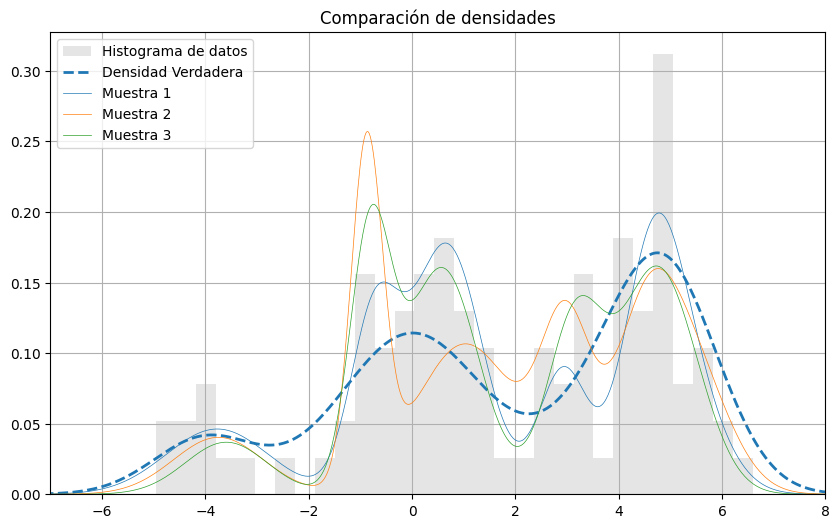

In [8]:
# Inicializar y entrenar el modelo Variational Bayes
vb = VariationalBayesGMM(n_components=6, max_iter=10000, tol=1e-20)

# Inicializar responsabilidades con EM para mejor convergencia
init_resp = em.predict_proba(X)

# Ajustar el modelo
vb.fit(X, init_resp=init_resp)

plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, density=True, alpha=0.2, color='gray', label='Histograma de datos')
plt.plot(x_plot, mezcla_verdadera_pdf(x_plot), 'C0--', lw=2, label='Densidad Verdadera')
for i in range(3):
    pi_s, mu_s, lambda_s = vb.sample_parameters()
    def pdf_vb(x):
        return sum([
            pi_s[k] * (1 / np.sqrt(2 * np.pi / lambda_s[k])) *
            np.exp(-0.5 * lambda_s[k] * (x - mu_s[k])**2)
            for k in range(6)
        ])
    plt.plot(x_plot, [pdf_vb(xi) for xi in x_plot], lw=0.5, label=f'Muestra {i+1}')
plt.legend()
plt.grid()
plt.title('Comparación de densidades')
plt.xlim(-7,8)
plt.show()


## Densidad predictiva

La densidad predictiva obtenida mediante inferencia variacional representa la esperanza de la distribución de datos bajo la distribución *a posteriori* de los parámetros del modelo.

A continuación, se grafica la densidad predictiva de VB comparada con la densidad verdadera, la estimación del EM y la de K-means.

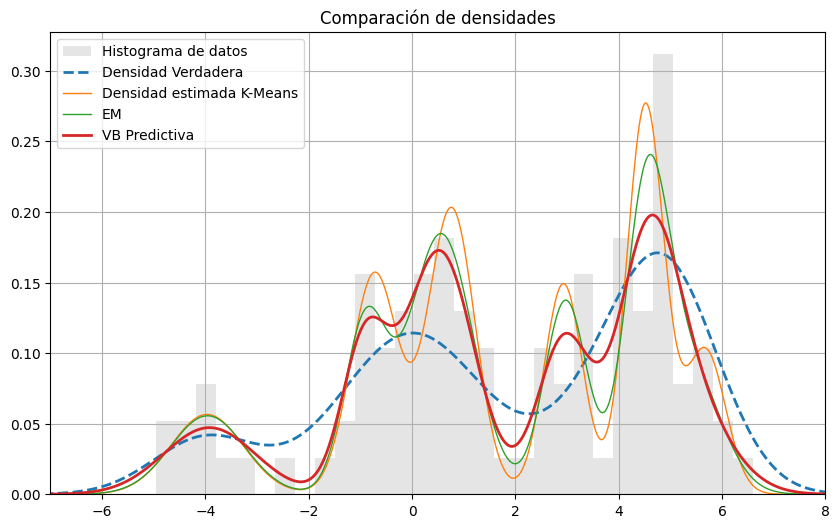

In [9]:
# Esperanza de los pesos de mezcla (pi_k) bajo la distribución posterior q(pi) ~ Dirichlet(alpha_)
# E[pi_k] = alpha_k / sum(alpha_)
E_pi = vb.alpha_ / np.sum(vb.alpha_)

# Esperanza de las medias (mu_k) bajo la distribución posterior q(mu_k, lambda_k)
# E[mu_k] = m_k
E_mu = vb.m_

# Esperanza de las varianzas (sigma^2_k) bajo la distribución posterior q(mu_k, lambda_k)
# Si nu_k <= 2, la esperanza de la varianza no está definida (tiende a infinito).
E_sigma2 = np.where(vb.nu_ > 2, vb.delta_ / (vb.nu_ - 2), np.inf)


# --- Definición de la función de densidad predictiva aproximada ---
def vb_predictive_density(x):
    # Suma las contribuciones de cada componente Gaussiana
    return sum(
        # Contribución de la componente k: E[pi_k] * N(x | E[mu_k], E[sigma^2_k])
        E_pi[k] * (1 / np.sqrt(2 * np.pi * E_sigma2[k])) *
        np.exp(-0.5 * (x - E_mu[k])**2 / E_sigma2[k])
        for k in range(len(E_pi)) # Itera sobre el número de componentes (igual a la longitud de E_pi)
        if np.isfinite(E_sigma2[k]) # Condición para incluir solo componentes con varianza finita
    )


# --- Graficación de las densidades comparadas ---
plt.figure(figsize=(10, 6))
plt.hist(X, bins=30, density=True, alpha=0.2, color='gray', label='Histograma de datos')
plt.plot(x_plot, mezcla_verdadera_pdf(x_plot), 'C0--', lw=2, label='Densidad Verdadera')
plt.plot(x_plot, mezcla_kmeans_pdf(x_plot), 'C1-', lw=1, label='Densidad estimada K-Means')
plt.plot(x_plot, mezcla_em_pdf(x_plot),'C2-', lw=1, label='EM')
plt.plot(x_plot, [vb_predictive_density(xi) for xi in x_plot],'C3-', lw=2, label='VB Predictiva')
plt.xlim(-7,8)
plt.legend()
plt.grid()
plt.title('Comparación de densidades')
plt.show()

Si bien K-means y EM ofrecen estimaciones útilies, la densidad predictiva de BV logra la mejor estimación, reduciendo el sobreajuste de EM y los picos de K-means.